In [1]:
from math import sqrt
import pde
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
from dateutil import parser
import numpy as np
from pde import PDE, FieldCollection, PlotTracker, ScalarField, UnitGrid
from IPython.display import HTML
from pde import DiffusionPDE, ScalarField, UnitGrid
from GPy.models import GPRegression
import GPy
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction
from emukit.core import ContinuousParameter, ParameterSpace
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
import itertools
from emukit.core.acquisition.acquisition_per_cost import acquisition_per_expected_cost
from emukit.core.interfaces.models import IModel
from sklearn.linear_model import LinearRegression
from emukit.experimental_design import ExperimentalDesignLoop



In [2]:
from mfed.pde import pde_runner
from mfed.plot import plot

In [ ]:
class CostModel(IModel):
    def __init__(self,X,c):
        self.clf = LinearRegression()
        self.clf.fit(X[:,0].reshape((-1,1)),c)
    def predict(self, X: np.ndarray):
        w = self.clf.predict(X[:,0].reshape((-1,1))).reshape((-1,1))
        return (w,X)


In [3]:
f_y = lambda x: len(np.where(x > 4.25)[0])
param = {"pde_name":"brusselator","t_range":10,"diff":1,"dt":1e-03,"seed":100,"dim_data":1,"f_y":f_y}
pde_client = pde_runner(param,f_y)

In [4]:
dt_list = [1e-1,1e-3]
diff_list = np.linspace(0.1,0.9,2)
X = np.array(list(itertools.product(diff_list,dt_list)))

Y = pde_client(X)




100%|██████████| 4/4 [01:27<00:00, 21.88s/it]


In [2]:

def plot(X,Y,model_variance):
    mesh_size=50
    x_1_space = np.linspace(X[:,0].min(),X[:,0].max(),mesh_size)
    x_2_space = np.linspace(X[:,1].min(),X[:,1].max(),mesh_size)
    xx, yy = np.meshgrid(x_1_space,x_2_space)
    X_mesh = np.hstack([xx.reshape((-1,1)),yy.reshape((-1,1))])
    utility = model_variance.evaluate(X_mesh).reshape((mesh_size,mesh_size))
    fig = go.Figure(data=[go.Surface(x=xx,y=yy,z=utility, opacity=0.7, showscale=False),
    go.Scatter3d(x=X[:,0],y=X[:,1],z=[utility.min()]*X.shape[0],mode="markers",marker_symbol="x",marker_size=5)])
    fig.show()


def get_PDE(param):
    if param["pde_name"] == "diffusion":
        grid = UnitGrid([64, 64])  # generate grid
        state = ScalarField.random_uniform(grid, 0.2, 0.3,rng=np.random.default_rng(seed=param["seed"]))  # generate initial condition
        eq = DiffusionPDE(diffusivity=param["diff"])  # define the pde
        #state.plot(title='Initial state')
    elif param["pde_name"] == "brusselator":
        a, b = 1, 3 # 1, 3
        d0, d1 = param["diff"], 0.1
        eq = PDE(
            {
                "u": f"{d0} * laplace(u) + {a} - ({b} + 1) * u + u**2 * v",
                "v": f"{d1} * laplace(v) + {b} * u - u**2 * v",
            }
        )

        # initialize state
        grid = UnitGrid([64, 64])
        u = ScalarField(grid, a, label="Field $u$")
        v = b / a + 0.1 * ScalarField.random_normal(grid, label="Field $v$",rng=np.random.default_rng(seed=param["seed"]))
        state = FieldCollection([u, v])
        #state.plot(title='Initial state')
    else:
        raise("Error")
    return eq,state

def run_PDE(param,plot_sol=False,store_video=False):
    eq,state = get_PDE(param)
    solver = pde.ExplicitSolver(eq,adaptive=False)
    solver.dt_max = param["dt"]
    solver.dt_min = param["dt"]
    storage = MemoryStorage()
    controller1 = pde.Controller(solver, t_range=param["t_range"], tracker=[storage.tracker(0.02)]) # 20
    sol = controller1.run(state, dt=param["dt"])
    if len(sol.data.shape)>2: # If there are more than one dimension in the PDE select the given one according to param 
        sol = sol.data[param["dim_data"],:,:].flatten()
    else:
        sol = sol.data.flatten()
    if plot_sol:
        sol.plot()
    if store_video:
        pde.visualization.movie(storage=storage,filename="./../assets/"+param["pde_name"]+"/"+"baseline"+".mp4")
    return {"param":param,"sol":sol,"storage":storage,"time":float(controller1.diagnostics["controller"]["profiler"]["solver"]),"controller":controller1}

def f_PDE(X):
    f = lambda x: len(np.where(x > 4.25)[0])
    Y = []
    param = {"pde_name":"brusselator","diff":1,"dt":1e-03,"t_range":10,"seed":100,"dim_data":1}
    for i in range(X.shape[0]):
        param["dt"] = X[i,0]
        param["diff"] = X[i,1]
        res = run_PDE(param)
        Y.append(f(res["sol"]))
    return np.array(Y).reshape((-1,1))



In [3]:

#

In [4]:
# Run the PDE with a few different hyper-parameters

param_list = []
dt_list = [1e-1,1e-3]
diff_list = np.linspace(0.1,0.9,2)
for diff,dt in itertools.product(diff_list,dt_list):
    param["dt"] = dt
    param["diff"] = diff
    param_list.append(param.copy())

result = list(map(run_PDE,param_list))


{'pde_name': 'brusselator', 'diff': 0.1, 'dt': 0.1, 't_range': 10, 'seed': 100, 'dim_data': 1}
{'pde_name': 'brusselator', 'diff': 0.1, 'dt': 0.001, 't_range': 10, 'seed': 100, 'dim_data': 1}
{'pde_name': 'brusselator', 'diff': 0.9, 'dt': 0.1, 't_range': 10, 'seed': 100, 'dim_data': 1}
{'pde_name': 'brusselator', 'diff': 0.9, 'dt': 0.001, 't_range': 10, 'seed': 100, 'dim_data': 1}


In [5]:
# Parse the results and extract all the values above the threshold 4.25 
f = lambda x: len(np.where(x > 4.25)[0])

X = [[i["param"]["dt"],i["param"]["diff"]]for i in result]
Y = [f(i["sol"]) for i in result]
c = [i["time"] for i in result]

# Standardize the data
X = np.array(X)
#X = StandardScaler(with_std=False).fit_transform(X)
Y = np.array(Y).reshape((-1,1))

# Boiler plate for plotting 
mesh_size = 50
space = ParameterSpace([ContinuousParameter('diff', X[:,0].min(), X[:,0].max()),
                        ContinuousParameter('dt', X[:,1].min(), X[:,1].max())])
x_monte_carlo = np.vstack([np.ones((mesh_size))*space.parameters[0].min,
                np.linspace(X[:,1].min(),X[:,1].max(),mesh_size)]).T



In [6]:

# Plot the initial data

fig = go.Figure(data=[go.Scatter3d(x=X[:,0],y=X[:,1],z=Y.reshape((-1)),mode="markers",marker_symbol="x",marker_size=5)])
fig.show()

In [7]:
# Define and fit a GP model 

kernel = GPy.kern.RBF(input_dim=2,ARD=True,lengthscale=[0.1,0.1],variance=1)
model_gpy = GPRegression(X,Y,kernel = kernel,normalizer=True,noise_var=0.05)
model_gpy.parameters[0].variance.fix()
model_gpy.parameters[1].variance.fix()
model_gpy.optimize()
print("Param: ",model_gpy.param_array)


Param:  [1.         0.12864017 0.1        0.05      ]


In [8]:



cost_model = CostModel(X,c) # Fit a linear model on the costs 


model_emukit = GPyModelWrapper(model_gpy)
model_variance = IntegratedVarianceReduction(model=model_emukit,space=space,x_monte_carlo=x_monte_carlo)

plot(X,Y,model_variance)





In [9]:

weighted_variance = acquisition_per_expected_cost(model_variance,cost_model)
plot(X,Y,weighted_variance)

In [10]:
def f_PDE(X):
    f = lambda x: len(np.where(x > 4.25)[0])
    Y = []
    param = {"pde_name":"brusselator","diff":1,"dt":1e-03,"t_range":10,"seed":100,"dim_data":1}
    for i in range(X.shape[0]):
        param["dt"] = X[i,0]
        param["diff"] = X[i,1]
        res = run_PDE(param)
        Y.append(f(res["sol"]))
    return np.array(Y).reshape((-1,1))


model_emukit = GPyModelWrapper(model_gpy)

expdesign_loop = ExperimentalDesignLoop(model = model_emukit,
                                        space = space,
                                        acquisition = weighted_variance,
                                        batch_size = 1)

{'pde_name': 'brusselator', 'diff': 0.49999715904095166, 'dt': 0.1, 't_range': 10, 'seed': 100, 'dim_data': 1}


[0.12469514712020088]
{'pde_name': 'brusselator', 'diff': 0.6993181939077461, 'dt': 0.1, 't_range': 10, 'seed': 100, 'dim_data': 1}


[0.12469514712020088, 0.11466114748003099]
{'pde_name': 'brusselator', 'diff': 0.38363264854484336, 'dt': 0.1, 't_range': 10, 'seed': 100, 'dim_data': 1}


[0.12469514712020088, 0.11466114748003099, 0.1248295422343801]
{'pde_name': 'brusselator', 'diff': 0.4970058658610432, 'dt': 0.062379003115046766, 't_range': 10, 'seed': 100, 'dim_data': 1}


[0.12469514712020088, 0.11466114748003099, 0.1248295422343801, 0.10004496032172802]
{'pde_name': 'brusselator', 'diff': 0.49860054610017157, 'dt': 0.017951634167327153, 't_range': 10, 'seed': 100, 'dim_data': 1}


[0.12469514712020088, 0.11466114748003099, 0.1248295422343801, 0.10004496032172802, 0.09026427225628203]
{'pde_name': 'brusselator', 'diff': 0.6604116002668556, 'dt': 0.1, 't_range': 10, 'seed': 100, 'dim_data': 1}


[0.12469514712020088, 0.11466114748003099, 0.1248295422343801, 0.10004496032172802, 0.09026427225628203, 0.08724361306501056]
{'pde_name': 'brusselator', 'diff': 0.3004290728537304, 'dt': 0.1, 't_range': 10, 'seed': 100, 'dim_data': 1}


[0.12469514712020088, 0.11466114748003099, 0.1248295422343801, 0.10004496032172802, 0.09026427225628203, 0.08724361306501056, 0.10129326840171432]
{'pde_name': 'brusselator', 'diff': 0.6862981163826964, 'dt': 0.052358065816391325, 't_range': 10, 'seed': 100, 'dim_data': 1}


[0.12469514712020088, 0.11466114748003099, 0.1248295422343801, 0.10004496032172802, 0.09026427225628203, 0.08724361306501056, 0.10129326840171432, 0.11058411201596662]
{'pde_name': 'brusselator', 'diff': 0.25882817475373066, 'dt': 0.1, 't_range': 10, 'seed': 100, 'dim_data': 1}


[0.12469514712020088, 0.11466114748003099, 0.1248295422343801, 0.10004496032172802, 0.09026427225628203, 0.08724361306501056, 0.10129326840171432, 0.11058411201596662, 0.12629890093272272]
{'pde_name': 'brusselator', 'diff': 0.2991275279337926, 'dt': 0.05839552287924634, 't_range': 10, 'seed': 100, 'dim_data': 1}


[0.12469514712020088, 0.11466114748003099, 0.1248295422343801, 0.10004496032172802, 0.09026427225628203, 0.08724361306501056, 0.10129326840171432, 0.11058411201596662, 0.12629890093272272, 0.11686466870876444]


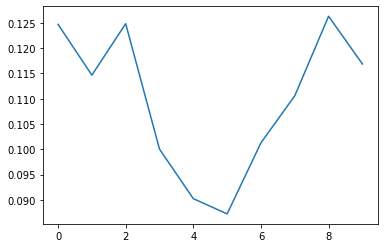

In [11]:
max_iterations = 10
l = []
for i in range(max_iterations):
    expdesign_loop.run_loop(f_PDE, 1)
    X_new = np.array([i.X for i in expdesign_loop.loop_state.results])
    Y_new = np.array([i.Y for i in expdesign_loop.loop_state.results])
    model_variance = IntegratedVarianceReduction(model=expdesign_loop.model,space=space,x_monte_carlo=x_monte_carlo)
    weighted_variance = acquisition_per_expected_cost(model_variance,cost_model)
    plot(np.vstack((X,X_new)),np.vstack((Y,Y_new)),weighted_variance)
    l.append(expdesign_loop.model.model.param_array[1])
    print(l)
plt.plot(l)

    

In [12]:
expdesign_loop.model.model.param_array

array([1.        , 0.11686467, 0.17435365, 0.05      ])

In [13]:
tmp

NameError: name 'tmp' is not defined